In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
#loading osprey data
osprey_path = '/content/drive/MyDrive/ml_climate_project_data/osprey/'

csv_files = [f for f in os.listdir(osprey_path) if f.endswith('.csv')]

osprey_df = pd.concat(
    [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
osprey_df['OBSERVATION COUNT'] = pd.to_numeric(osprey_df['OBSERVATION COUNT'], errors = 'coerce')
osprey_df = osprey_df.dropna(subset = ['OBSERVATION COUNT'])

osprey_df = osprey_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

#display 5 rows
osprey_df.head()

<ipython-input-4-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-4-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-4-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-4-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-4-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.


,OBSERVATION DATE,OBSERVATION COUNT,COUNTY
0,1994-01-09,1.0,Los Angeles
1,1994-01-08,1.0,Marin
3,1994-01-13,1.0,Monterey
4,1994-01-17,1.0,Monterey
6,1994-01-15,1.0,Orange


In [5]:
#loading bald_eagle data
eagle_path = '/content/drive/MyDrive/ml_climate_project_data/bald_eagle/'

csv_files = [f for f in os.listdir(eagle_path) if f.endswith('.csv')]
bald_eagle_df = pd.concat(
    [pd.read_csv(os.path.join(eagle_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
bald_eagle_df['OBSERVATION COUNT'] = pd.to_numeric(bald_eagle_df['OBSERVATION COUNT'], errors = 'coerce')
bald_eagle_df = bald_eagle_df.dropna(subset = ['OBSERVATION COUNT'])

bald_eagle_df = bald_eagle_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

#displaying 5 rows
bald_eagle_df.head()

,OBSERVATION DATE,OBSERVATION COUNT,COUNTY
0,1994-01-09,1.0,Del Norte
1,1994-01-04,1.0,Del Norte
2,1994-01-16,1.0,Del Norte
3,1994-01-09,1.0,Del Norte
4,1994-01-20,2.0,Del Norte


In [6]:
#fish data
fish_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/fishdata.csv')

In [7]:
#temperature data
temp_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/tempdata.csv')

temp_df = temp_df[temp_df['Anomaly'] != -999]

temp_df['year'] = temp_df['Date'].astype(str).str[:4].astype(int)
temp_df['month'] = temp_df['Date'].astype(str).str[4:].astype(int)

In [8]:
#combine and join data
osprey_df["bird_type"] = "Osprey"
bald_eagle_df["bird_type"] = "Bald Eagle"
bird_df = pd.concat([osprey_df, bald_eagle_df], ignore_index = True)

bird_df['OBSERVATION DATE'] = pd.to_datetime(bird_df['OBSERVATION DATE'])
bird_df['year'] = bird_df['OBSERVATION DATE'].dt.year
bird_df['month'] = bird_df['OBSERVATION DATE'].dt.month

#combine with temperature data
bird_temp_df = bird_df.merge(temp_df[['year', 'month', 'Anomaly']], on=['year', 'month'], how='left')

#combine with fish data
combined_df = bird_temp_df.merge(fish_df, on='year', how='left')
final_df = combined_df.dropna()
final_df = final_df.rename(columns={
    "Anomaly": "temperature",
    "OBSERVATION COUNT": "bird_count",
    "Fish_Population": "fish_population",
})
print(final_df.head(10))

   OBSERVATION DATE  bird_count       COUNTY bird_type  year  month  \
0        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
2        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
3        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
4        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
12       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
13       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
14       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
15       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
19       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
36       1994-01-09         1.0  Los Angeles    Osprey  1994      1   

    temperature  Unnamed: 0    species      spawners       runsize  
0          0.89        12.0    Chinook  6.491291e+04  1.939712e+05  
2          0.89       104.0    Chinook  9.743200e+04  1.125201e+05  
3          

DATA VISUALIZATION

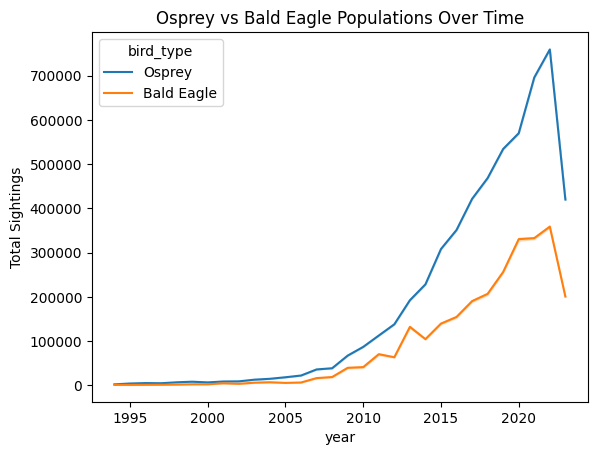

In [18]:
#visualizing data - population trends over time: are bald eagles becoming more dominant over time?

sns.lineplot(data = final_df, x = "year", y = "bird_count", hue = "bird_type", estimator = "sum")
plt.title("Osprey vs Bald Eagle Populations Over Time")
plt.ylabel("Total Sightings")
plt.show()

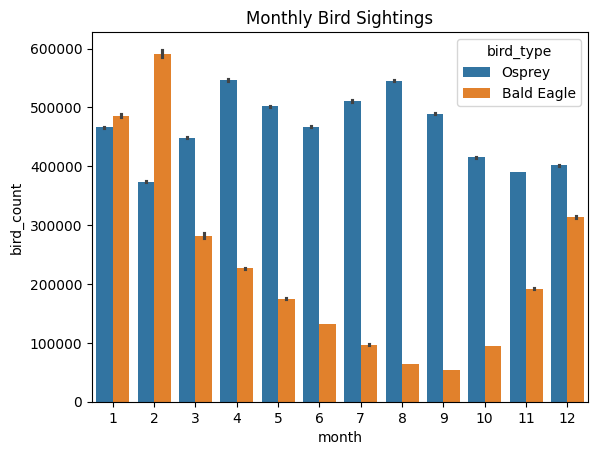

In [19]:
#visualizing data - monthly bird patterns: hunting/breeding or seasonal shifts

sns.barplot(data = final_df, x = "month", y = "bird_count", hue = "bird_type", estimator = "sum")
plt.title("Monthly Bird Sightings")
plt.show()

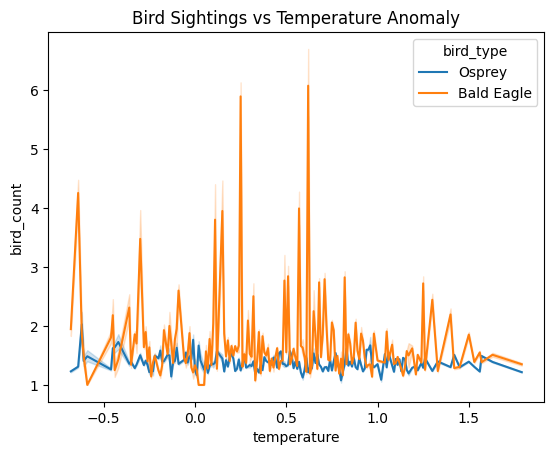

In [21]:
#visualizing data - population vs temperature: correlation between temperature and bird population

sns.lineplot(data = final_df, x = "temperature", y = "bird_count", hue = "bird_type")
plt.title("Bird Sightings vs Temperature Anomaly")
plt.show()

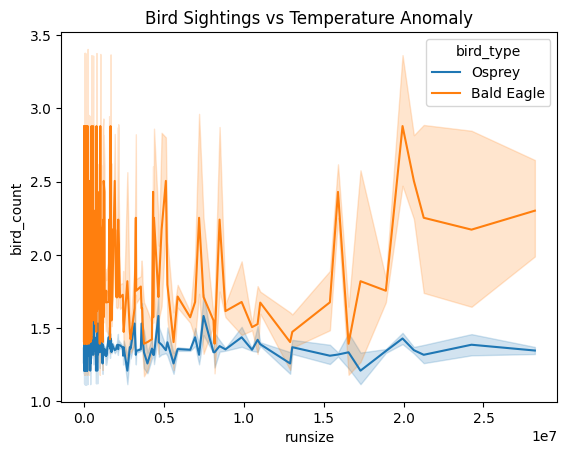

In [24]:
#visualizing data - population vs fish count: r*theory, who survives better with less fish

sns.lineplot(data = final_df, x = "runsize", y = "bird_count", hue = "bird_type")
plt.title("Bird Sightings vs Temperature Anomaly")
plt.show()

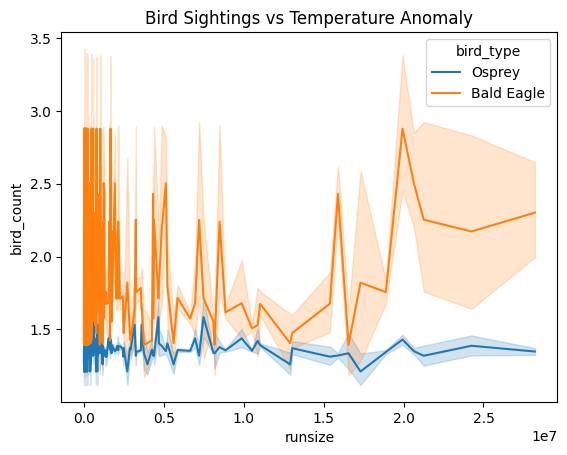

In [25]:
#visualizing data - fish vs temperature: how does fish count change with temperature over time

sns.lineplot(data = final_df, x = "runsize", y = "bird_count", hue = "bird_type")
plt.title("Bird Sightings vs Temperature Anomaly")
plt.show()

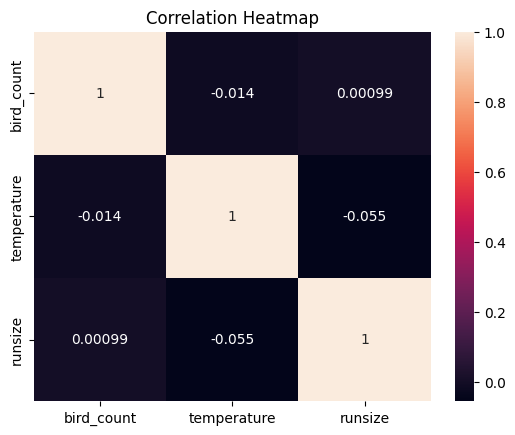

In [26]:
#visualizing data - correlation heatmap

corr = final_df[["bird_count", "temperature", "runsize"]].corr()
sns.heatmap(corr, annot = True)
plt.title("Correlation Heatmap")
plt.show()

In [26]:
#data setup

final_df['interaction_temp_osprey'] = final_df['temperature'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_temp_bald_eagle'] = final_df['temperature'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)
final_df['interaction_fish_osprey'] = final_df['runsize'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_fish_bald_eagle'] = final_df['runsize'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)

features = ['temperature', 'runsize', 'interaction_temp_osprey', 'interaction_temp_bald_eagle',
            'interaction_fish_osprey', 'interaction_fish_bald_eagle']
target = 'bird_count'
X = final_df[features].values
y = final_df[target].values
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(X_tensor.shape)
print(y_tensor.shape)

torch.Size([5662717, 6])
torch.Size([5662717, 1])


In [27]:
#basic neural network
class CausalSEM(nn.Module):
    def __init__(self, input_dim):
        super(CausalSEM, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


In [28]:
#model setup

input_dim = X_tensor.shape[1]
model = CausalSEM(input_dim)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()
num_epochs = 10

In [29]:
#training

for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = loss_fn(predictions, y_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

predictions = model(X_tensor)
print(predictions[:5])

Epoch 0, Loss: 41365618688.0
Epoch 1, Loss: 28081283072.0
Epoch 2, Loss: 17742288896.0
Epoch 3, Loss: 10550767616.0
Epoch 4, Loss: 6238769664.0
Epoch 5, Loss: 3657237504.0
Epoch 6, Loss: 2279953664.0
Epoch 7, Loss: 1838148480.0
Epoch 8, Loss: 1998697216.0
Epoch 9, Loss: 2432328960.0
tensor([[-1862.3247],
        [-1080.3479],
        [-3804.0845],
        [-2038.5586],
        [ -315.6056]], grad_fn=<SliceBackward0>)


In [30]:
#counterfactual for temperature
X_counterfactual = X_tensor.clone()
X_counterfactual[:, final_df.columns.get_loc("temperature")] *= 1.1
y_counterfactual = model(X_counterfactual)

print(f"Predicted Bird Count with Increased Temperature: {y_counterfactual.mean()}")

IndexError: index 6 is out of bounds for dimension 1 with size 6

In [31]:
#counterfactual for fish population

X_counterfactual_decreased_fish = X_tensor.clone()
X_counterfactual_decreased_fish[:, final_df.columns.get_loc("runsize")] *= 0.8
y_counterfactual_decreased_fish = model(X_counterfactual_decreased_fish)

print(f"Predicted Bird Count with Decreased Fish Runsize: {y_counterfactual_decreased_fish.mean()}")

IndexError: index 10 is out of bounds for dimension 1 with size 6